In [17]:
import sys, os, json
sys.path.append(os.getcwd())  # 确保能导入当前目录下的模块
from polygen_suite import generate_with_marks, generate_complexity_cases
from viz_suite import render_triptych_from_polys, render_triptych_hulls
from melkman_analysis import analyze_melkman_complexity

In [19]:
def melkman_convex_hull(polygon, test: bool = False):
    """
    Melkman's algorithm: convex hull of a simple polygon given in boundary order.
    Input:  polygon -> sequence/deque of (x, y), simple polygon, overall non-collinear
    Output:
        - test=False: list of hull vertices in CCW order, without duplicated end point.
        - test=True : dict 计数信息（不返回凸包）
    """
    from collections import deque

    # ---- 计数器 ----
    C = {
        "cross": 0,
        "orient": 0,
        "is_left": 0,
        "append": 0,
        "appendleft": 0,
        "pop": 0,
        "popleft": 0,
        "while_top_iters": 0,   # 上链 while 循环迭代次数
        "while_bot_iters": 0    # 下链 while 循环迭代次数
    }

    # ---- 带计数的局部 helper ----
    def cross(ax, ay, bx, by):
        C["cross"] += 1
        return ax * by - ay * bx

    def orient(a, b, c):
        C["orient"] += 1
        return cross(b[0]-a[0], b[1]-a[1], c[0]-a[0], c[1]-a[1])

    def is_left(a, b, c):
        C["is_left"] += 1
        return orient(a, b, c) > 0.0

    def area2(poly):
        s = 0.0
        for i in range(len(poly)):
            x1, y1 = poly[i]
            x2, y2 = poly[(i + 1) % len(poly)]
            s += cross(x1, y1, x2, y2)
        return s

    # ---- 主体 ----
    pts = deque(polygon)
    n = len(pts)
    if n < 3:
        if test:
            C_out = {**C, "n": n, "hull_len": n}
            C_out["total_ops"] = sum(C[k] for k in ("cross","orient","is_left","append","appendleft","pop","popleft"))
            return C_out
        return list(pts)

    # 找到首个非共线三元组；若不存在说明输入不符合“整体非共线”的要求
    p0, p1 = pts[0], pts[1]
    k, o = 2, 0.0
    while k < n:
        o = orient(p0, p1, pts[k])
        if o != 0.0:
            break
        k += 1

    p2 = pts[k]
    D = deque()
    if o > 0.0:  # p0, p1, p2 is CCW
        D.append(p2);          C["append"] += 1
        D.append(p0);          C["append"] += 1
        D.append(p1);          C["append"] += 1
        D.append(p2);          C["append"] += 1
    else:        # make it CCW by swapping p0,p1
        D.append(p2);          C["append"] += 1
        D.append(p1);          C["append"] += 1
        D.append(p0);          C["append"] += 1
        D.append(p2);          C["append"] += 1

    # 扫描其余点
    used = {0, 1, k}
    order = [i for i in range(n) if i not in used]
    for i in order:
        p = pts[i]
        # 在当前凸包内部则跳过
        if is_left(D[0], D[1], p) and is_left(D[-2], D[-1], p):
            continue
        # 调整上链
        while not is_left(D[0], D[1], p):
            D.popleft();       C["popleft"] += 1; C["while_top_iters"] += 1
        D.appendleft(p);       C["appendleft"] += 1
        # 调整下链
        while not is_left(D[-2], D[-1], p):
            D.pop();           C["pop"] += 1; C["while_bot_iters"] += 1
        D.append(p);           C["append"] += 1

    # 去尾部重复点
    D.pop();                   C["pop"] += 1
    hull = list(D)
    if area2(hull) < 0.0:
        hull.reverse()

    if test:
        C_out = {**C, "n": n, "hull_len": len(hull)}
        C_out["total_ops"] = sum(C[k] for k in ("cross","orient","is_left","append","appendleft","pop","popleft"))
        return C_out
    return hull

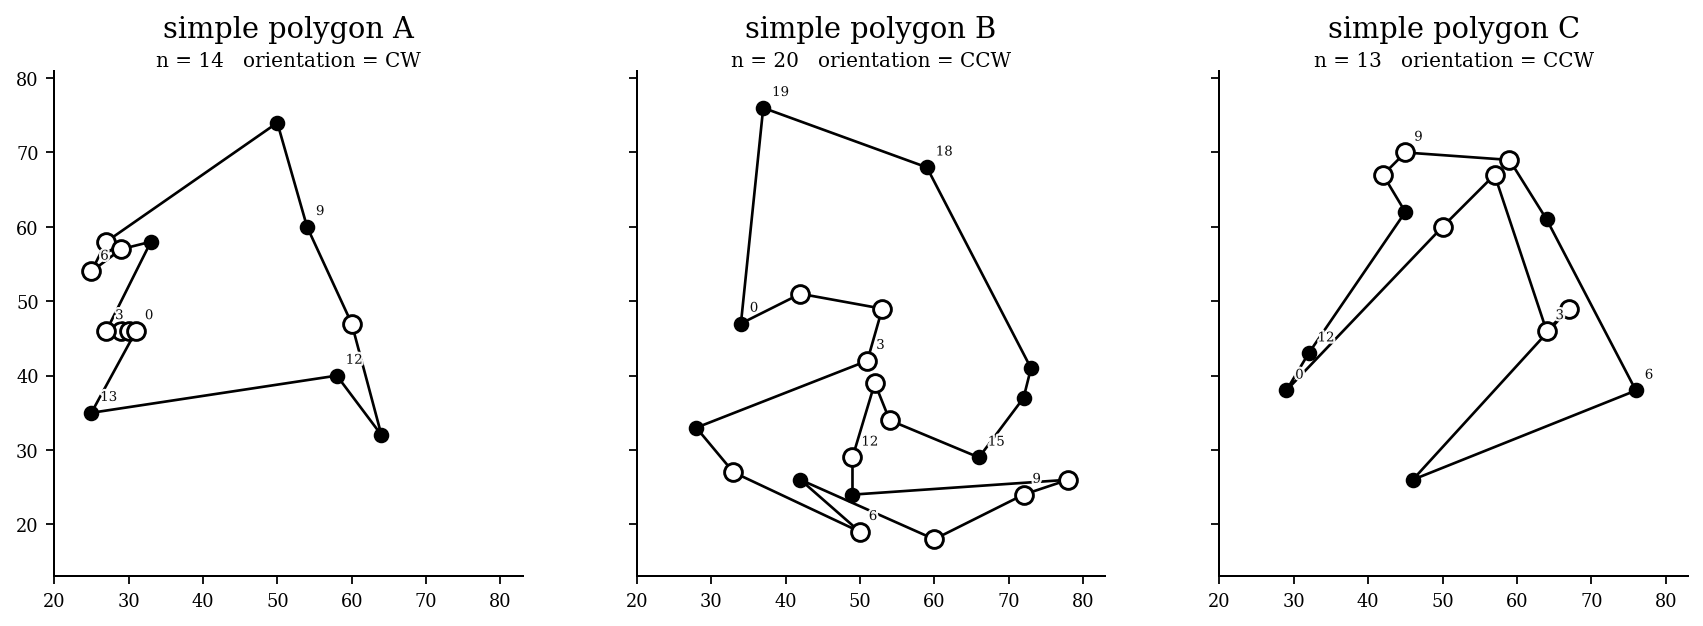

In [20]:
# 生成三类 polygon，并分别获得插入点集合
PolyA, MarkA = generate_with_marks("A")
PolyB, MarkB = generate_with_marks("B")
PolyC, MarkC = generate_with_marks("C")

Polys = [PolyA, PolyB, PolyC]
Marks = [MarkA, MarkB, MarkC]
Polys_Marks = [(PolyA, MarkA), (PolyB, MarkB), (PolyC, MarkC)]

render_triptych_from_polys(Polys_Marks)

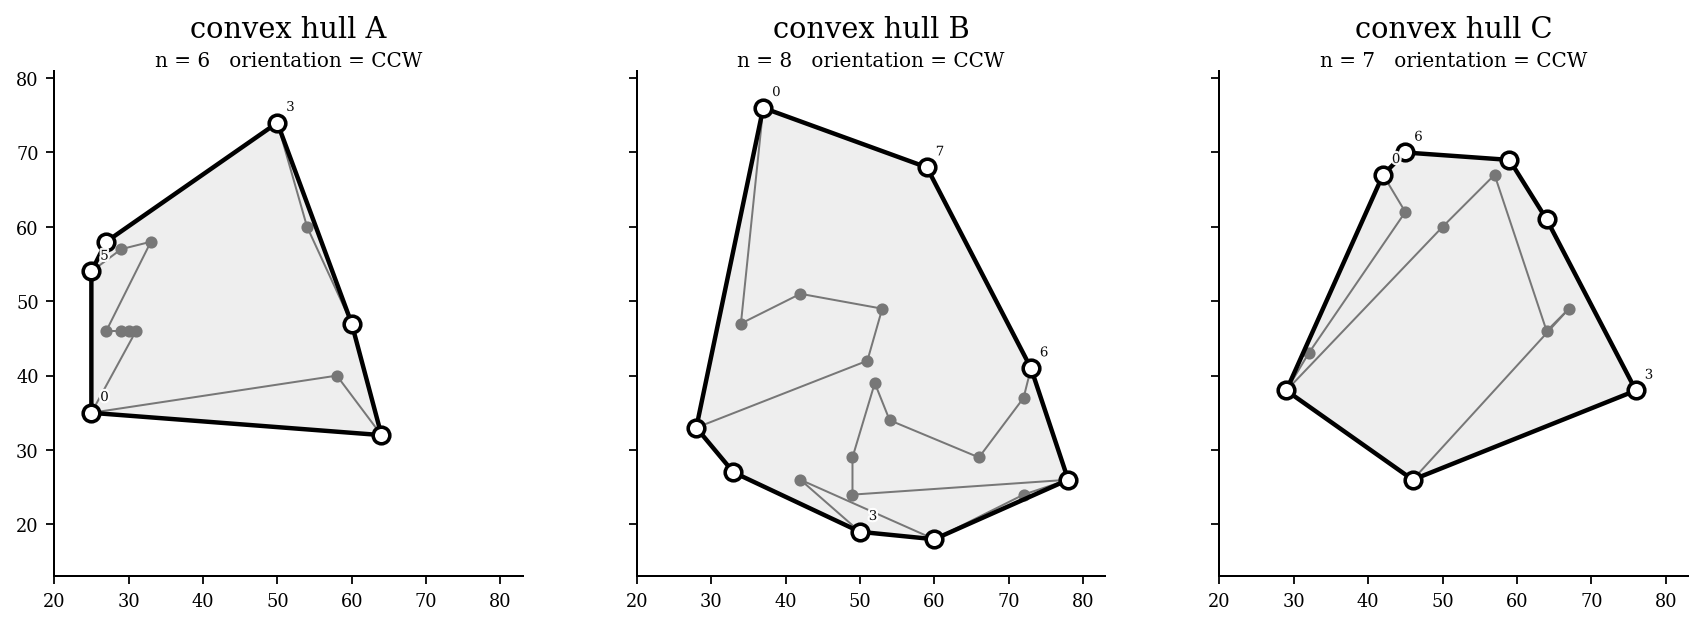

In [21]:
HullA = melkman_convex_hull(PolyA)
HullB = melkman_convex_hull(PolyB)
HullC = melkman_convex_hull(PolyC)

Polys_and_Hulls = [(PolyA,HullA), (PolyB,HullB), (PolyC,HullC)]
render_triptych_hulls(Polys_and_Hulls)

In [6]:
stats = melkman_convex_hull(PolyA, test=True)

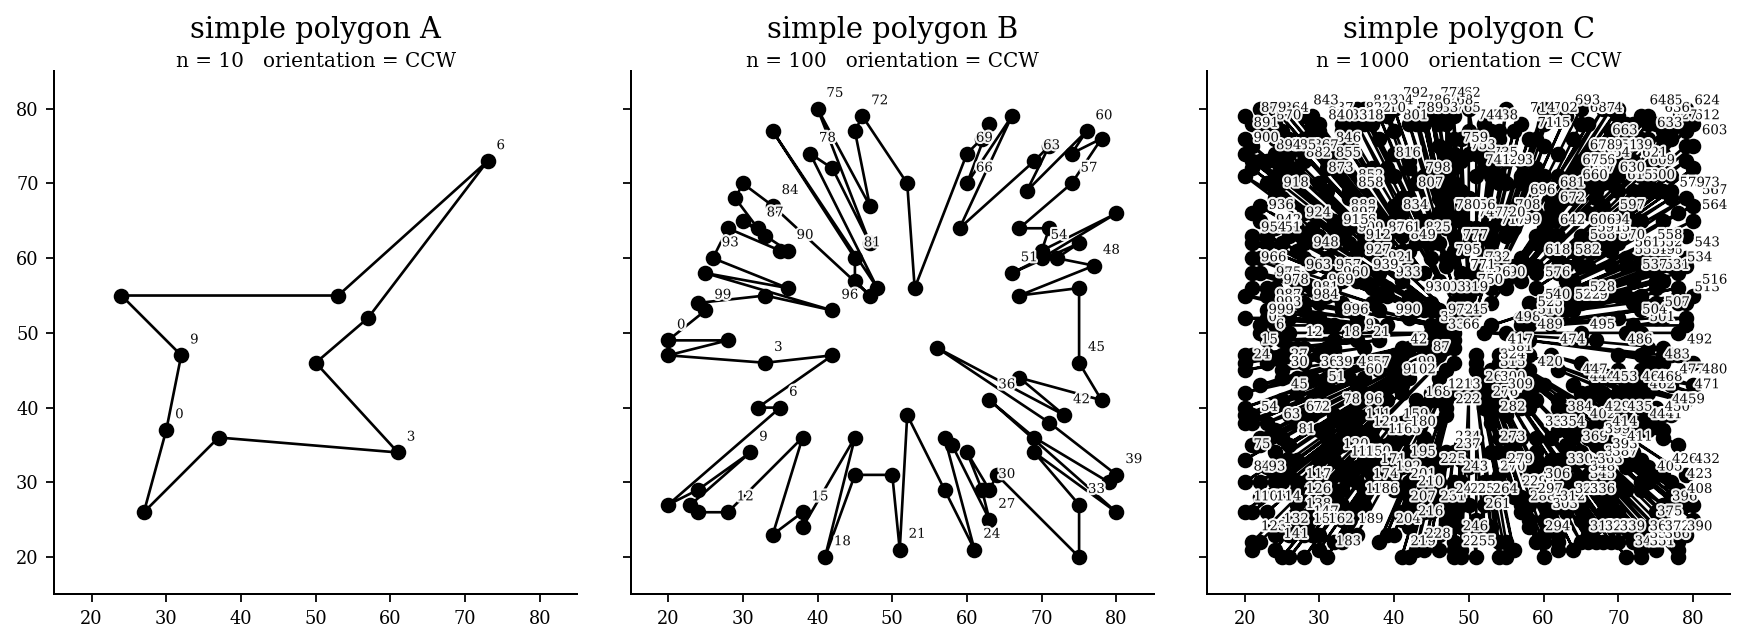

In [25]:
cases = generate_complexity_cases("params.json")
P10, P100, P1000 = cases[10], cases[100], cases[1000]
complex_cases = [P10, P100, P1000]
render_triptych_from_polys(complex_cases)

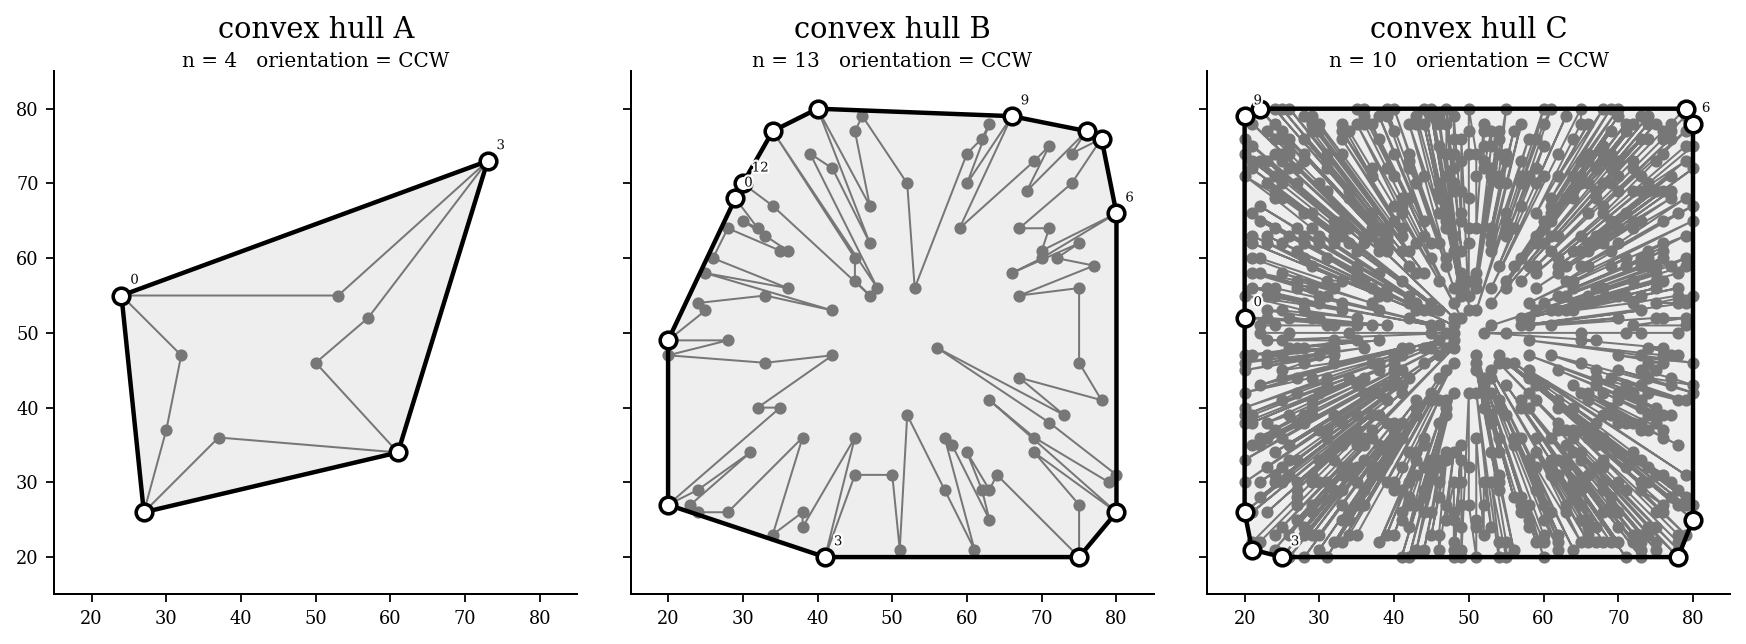

In [26]:
cases = generate_complexity_cases("params.json")
P10, P100, P1000 = cases[10], cases[100], cases[1000]
complex_cases = [P10, P100, P1000]
Polys_and_Hulls = [(P10,HullP10), (P100,HullP100), (P1000,HullP1000)]
render_triptych_hulls(Polys_Hulls)

In [27]:
stats10 = melkman_convex_hull(P10)
stats100 = melkman_convex_hull(P100)
stats1000 = melkman_convex_hull(P1000)
complex_stats = [stats10, stats100, stats1000]

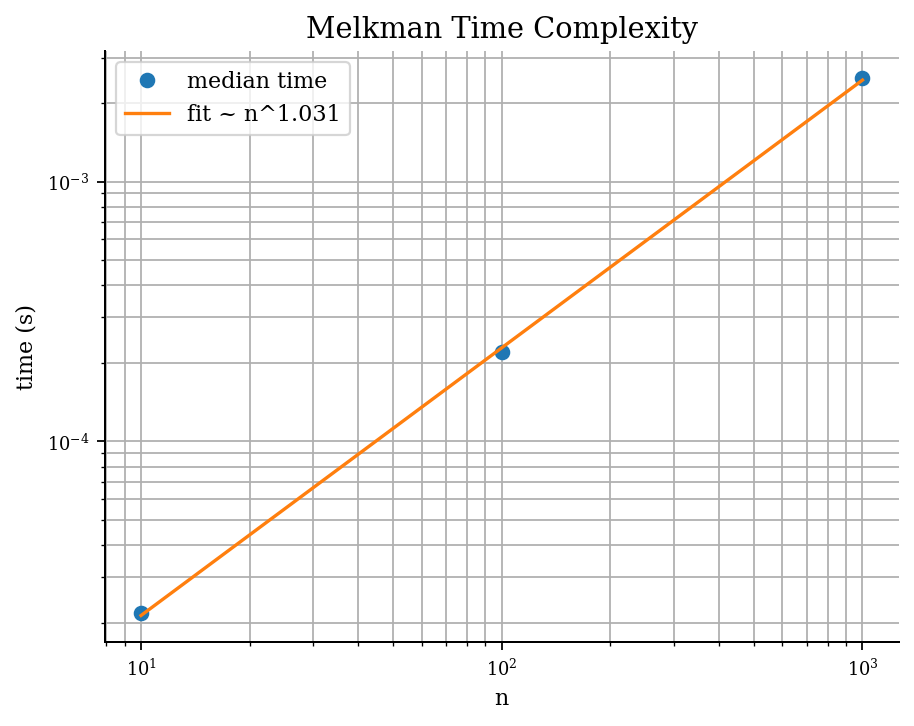

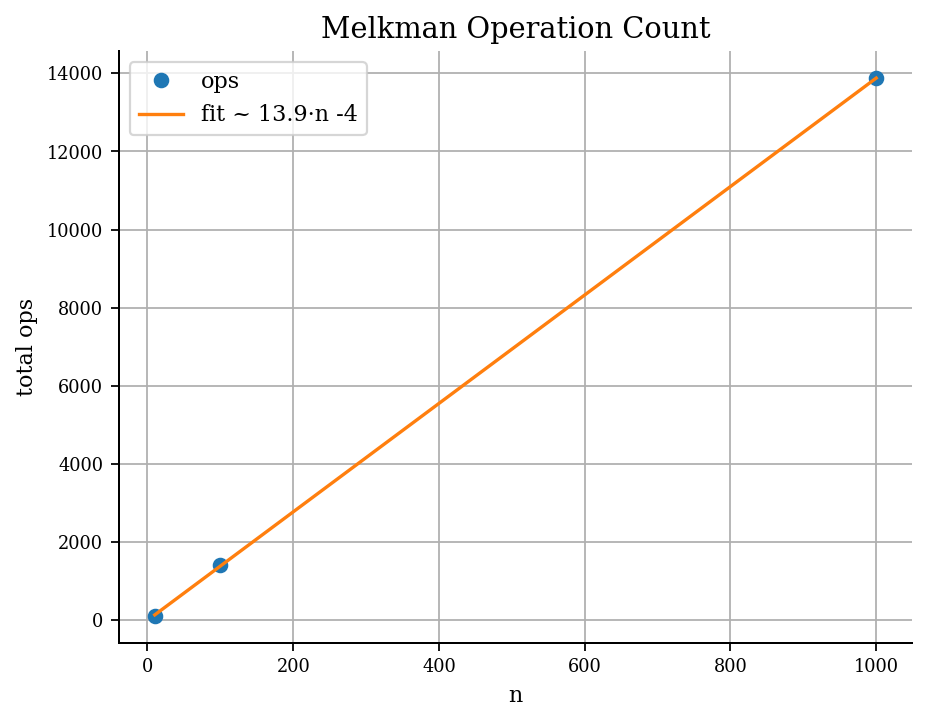

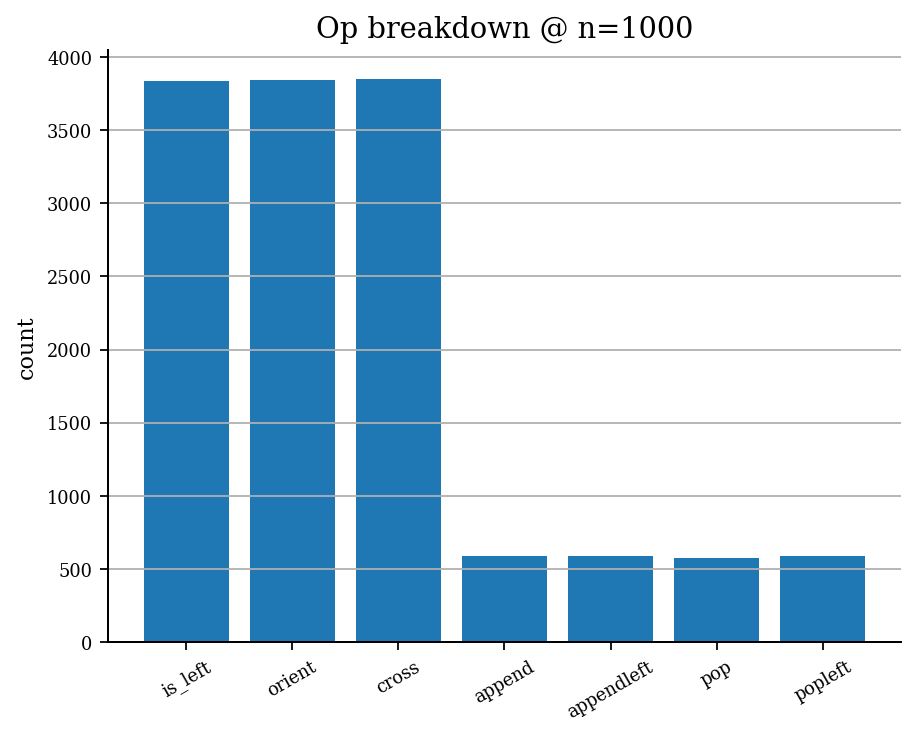

In [28]:
report = analyze_melkman_complexity(complex_cases, complex_stats, melkman_convex_hull, runs=7, show=True)

In [29]:
report

{'ns': [10, 100, 1000],
 'times': [2.1791987819597125e-05,
  0.00022045898367650807,
  0.002508125005988404],
 'ops': [114, 1407, 13876],
 'time_doubling': [10.117, 11.377],
 'ops_per_n': [11.4, 14.07, 13.876],
 'k_time': 1.0305261653132105,
 'a_ops': 13.882132132132131,
 'r2_time': 0.9993610102271611,
 'r2_ops': 0.9999917126402639,
 'breakdown_last': {'cross': 3853,
  'orient': 3843,
  'is_left': 3838,
  'append': 590,
  'appendleft': 586,
  'pop': 577,
  'popleft': 589,
  'while_top_iters': 589,
  'while_bot_iters': 576,
  'n': 1000,
  'hull_len': 10,
  'total_ops': 13876}}